In [61]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers

In [62]:
'''
讀取數據並分析
'''
# 讀取寶可夢數據
pokemon_df = pd.read_csv('pokemon.csv')  
pokemon_df.head()  # 顯示前5筆資料
# 將"#"數據設定為索引值：
pokemon_df= pokemon_df.set_index("#")  # 將索引設定為'#'列
pokemon_df.head()  # 顯示前5筆資料
# 讀取寶可夢對戰數據：
# 讀取對戰數據
combats_df = pd.read_csv('combats.csv')  
combats_df.head()  # 顯示前5筆資料
# 補齊缺失資料
pokemon_df.info()  # 顯示精靈寶可夢的數據資訊
# 查看Type2每個類別的數量：
# 填補缺失數據：使用empty將缺失的欄位填上。
pokemon_df["Type 2"].fillna('empty',inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB


In [63]:
'''
數據前處理
'''

# print(combats_df.dtypes)  # 顯示對戰數據的資料型態
# print('-' * 30)
# print(pokemon_df.dtypes)  # 顯示寶可夢數據的資料型態
# 轉換數據格式
pokemon_df['Type 1'] = pokemon_df['Type 1'].astype('category')  # 將'Type 1'轉成category型態
pokemon_df['Type 2'] = pokemon_df['Type 2'].astype('category')  # 將'Type 2'轉成category型態
pokemon_df['Legendary'] = pokemon_df['Legendary'].astype('int')  # 將'Legendary'轉成int型態
# print(pokemon_df.dtypes)  # 顯示目前寶可用數據集資料型態

# 將寶可夢的Type1和Type2轉為One-hot Encoding表示：
df_type1_one_hot = pd.get_dummies(pokemon_df['Type 1'])  # 取得'Type 1'數據的One-hot編碼
# 使用Pandas的get_dummies函數，取得Type2（寶可夢第二種屬性）
# 的One-hot Encoding：
df_type2_one_hot = pd.get_dummies(pokemon_df['Type 2'])  # 取得'Type 2'數據的One-hot編碼
# 將兩組One-hot Encoding合併回數據集：
# 將上方兩個One-hot編碼資料加起來，將缺少的值補0，並轉呈int64型態
combine_df_one_hot = df_type1_one_hot.add(df_type2_one_hot, fill_value=0).astype('int64')
# 將顯示列數設定為30，不然會有部份資料無法顯示
pd.options.display.max_columns = 30
# 將One-hot編碼資料加到寶可夢數據中
pokemon_df = pokemon_df.join(combine_df_one_hot)
# 將寶可夢屬性轉為數值表示（0, 1, 2, …18）：透過cat.categories查詢類別的標籤。
dict(enumerate(pokemon_df['Type 2'].cat.categories))
#　透過cat.codes可以取得類別的編碼值。
print("透過cat.codes可以取得類別的編碼值")
print(pokemon_df['Type 2'].cat.codes.head(10))
# 用數值表示（0, 1, 2…18）取代原本的標籤值：
pokemon_df['Type 1'] = pokemon_df['Type 1'].cat.codes # 屬性轉成數字
pokemon_df['Type 2'] = pokemon_df['Type 2'].cat.codes
pokemon_df.head()  # 顯示前5筆資料
# 將沒有使用到的資料剔除（name）：
pokemon_df.drop('Name', axis='columns', inplace=True)
pokemon_df.head()  # 顯示前5筆資料
# 將寶可夢對戰數據中勝利方的表示改為0與1：
# apply方法第一個參數為自訂function,而axis為columns的話會將數據一行一行放入function中處理，最後將所有結果組合成一個數據結構返回。
combats_df['Winner'] = combats_df.apply(lambda x: 0 if x.Winner == x.First_pokemon else 1, axis='columns')
combats_df.head()  # 顯示前5筆資料
print(pokemon_df['Type 1'])


透過cat.codes可以取得類別的編碼值
#
1     13
2     13
3     13
4     13
5     18
6     18
7      7
8      2
9      7
10    18
dtype: int8
#
1       9
2       9
3       9
4       9
5       6
       ..
796    15
797    15
798    14
799    14
800     6
Name: Type 1, Length: 800, dtype: int8


In [64]:
'''
分割數據集（對戰）
'''
data_num = combats_df.shape[0]
print(data_num)
# .shape[0] 獲取 combats_df DataFrame 的行數
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡劃分比例為6:2:2
# 將亂數索引分割為訓練集（60%）、驗證集（20%）和測試集（20%）
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過上方的索引值從對戰數據中提取資料
train_data = combats_df.loc[train_indexes]
val_data = combats_df.loc[val_indexes]
test_data = combats_df.loc[test_indexes]
print(train_data)

50000
       First_pokemon  Second_pokemon  Winner
34370            173             175       1
48042            654             134       1
14699            176             739       1
978              586             751       1
36834            797             637       0
...              ...             ...     ...
7684              40             365       1
892              583             450       0
5545             499             191       0
25773            394             402       0
1680             335             743       0

[30000 rows x 3 columns]


In [65]:
'''
Normalization 標準化
'''
print(pokemon_df['Type 1'])
print(pokemon_df)
pokemon_df['Type 1'] = pokemon_df['Type 1'] / 19
pokemon_df['Type 2'] = pokemon_df['Type 2'] / 19
# 這兩行代碼將 "Type 1" 和 "Type 2" 列（這些列已被轉換為類別代碼，範圍從0到18）進行歸一化處理
# 使其數值在0到1之間。此處除以的數字19是基於類別代碼的最大值（18），加1以避免將最大值除後超出1。
# 這種歸一化有助於後續模型處理數據時更加平衡和穩定。
mean = pokemon_df.loc[:, 'HP':'Generation'].mean()  # 計算平均值
std = pokemon_df.loc[:, 'HP':'Generation'].std()  # 計算標準差
# 標準化數據
pokemon_df.loc[:,'HP':'Generation'] = (pokemon_df.loc[:,'HP':'Generation']-mean)/std
# "HP" 到 "Generation" 列的數據進行標準化，標準化的公式是：(原始數據 - 平均值) / 標準差。
# 這種標準化處理將數據轉換為均值為0、標準差為1的分佈
pokemon_df.head()

#
1       9
2       9
3       9
4       9
5       6
       ..
796    15
797    15
798    14
799    14
800     6
Name: Type 1, Length: 800, dtype: int8
     Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  \
#                                                                               
1         9      13  45      49       49       65       65     45           1   
2         9      13  60      62       63       80       80     60           1   
3         9      13  80      82       83      100      100     80           1   
4         9      13  80     100      123      122      120     80           1   
5         6      18  39      52       43       60       50     65           1   
..      ...     ...  ..     ...      ...      ...      ...    ...         ...   
796      15       4  50     100      150      100      150     50           6   
797      15       4  50     160      110      160      110    110           6   
798      14       8  80     110       6

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.473684,0.684211,-0.950032,-0.924328,-0.796655,-0.238981,-0.248033,-0.801002,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0.473684,0.684211,-0.362595,-0.523803,-0.347700,0.219422,0.290974,-0.284837,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.473684,0.684211,0.420654,0.092390,0.293665,0.830626,1.009651,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0.473684,0.684211,0.420654,0.646964,1.576395,1.502951,1.728328,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,0.315789,0.947368,-1.185007,-0.831899,-0.989065,-0.391782,-0.787041,-0.112782,-1.398762,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [66]:
'''
建立Numpy array格式的訓練數據
'''
# 這些行將訓練數據（train_data）、驗證數據（val_data）和測試數據（test_data）中的特徵（x）和標籤（y）分開。特徵是通過移除目標列（Winner）來獲得的，而標籤則直接從目標列提取。
x_train_index = np.array(train_data.drop('Winner', axis='columns'))
x_val_index = np.array(val_data.drop('Winner', axis='columns'))
x_test_index = np.array(test_data.drop('Winner', axis='columns'))
# 準備訓練目標
y_train = np.array(train_data['Winner'])
y_val = np.array(val_data['Winner'])
y_test = np.array(test_data['Winner'])
# 準備兩種輸入數據：
#第一種：寶可夢的屬性為數值表示。
# 取得寶可夢的能力值
pokemon_data_normal = np.array(pokemon_df.loc[:, :'Legendary'])
# 透過前面準備的索引產生輸入數據
x_train_normal = pokemon_data_normal[x_train_index -1].reshape((-1, 20))
x_val_normal = pokemon_data_normal[x_val_index -1].reshape((-1, 20))
x_test_normal = pokemon_data_normal[x_test_index -1].reshape((-1, 20))
#第二種：寶可夢的屬性為One-hot encoding表示。
# 取得寶可夢的能力值
pokemon_data_one_hot = np.array(pokemon_df.loc[:, 'HP':])
# 透過前面準備的索引產生輸入數據
x_train_one_hot = pokemon_data_one_hot[x_train_index -1].reshape((-1, 54))
x_val_one_hot = pokemon_data_one_hot[x_val_index -1].reshape((-1, 54))
x_test_one_hot = pokemon_data_one_hot[x_test_index -1].reshape((-1, 54))

In [67]:
'''
使用數值編碼訓練網路（Model 1）
'''
inputs = keras.Input(shape=(20, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度類別數量，並且使用sigmoid激活函數
outputs = layers.Dense(1, activation='sigmoid')(x)
# outputs = layers.Dense(1)(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構
model_dir = 'lab3-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir, exist_ok=True)  # 創建儲存權重目錄，如果目錄已存在則忽略錯誤

# 儲存訓練記錄檔
log_dir = os.path.join('lab3-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.keras', monitor='val_binary_accuracy', save_best_only=True, mode='max')
model_1.compile(keras.optimizers.Adam(),
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=[keras.metrics.BinaryAccuracy()])
history_1 = model_1.fit(x_train_normal, y_train, 
                batch_size=64 ,
                epochs=200, 
                validation_data=(x_val_normal, y_val),
                callbacks=[model_cbk, model_mckp])


Model: "model-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:695: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7534 - loss: 0.5178 - val_binary_accuracy: 0.9156 - val_loss: 0.2862
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8868 - loss: 0.3408 - val_binary_accuracy: 0.9291 - val_loss: 0.2133
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9046 - loss: 0.2841 - val_binary_accuracy: 0.9337 - val_loss: 0.1907
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9179 - loss: 0.2374 - val_binary_accuracy: 0.9384 - val_loss: 0.1825
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9248 - loss: 0.2186 - val_binary_accuracy: 0.9372 - val_loss: 0.1825
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9274 - loss: 0.2150 - val_binary_accuracy: 0.9436 - val_loss: 0.1750
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - binary_accuracy: 0.9305 - loss: 0.2103 - val_binary_accuracy: 0.9432 - val_loss: 0.1711
Epoch 8/2

In [68]:
'''
使用One-hot編碼訓練網路（Model 2）
'''
inputs = keras.Input(shape=(54, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度為類別數量，並且使用sigmoid激活函數
# outputs = layers.Dense(1)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構
# 儲存訓練記錄檔
log_dir = os.path.join('lab3-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.keras', 
                                         monitor='val_binary_accuracy', save_best_only=True, mode='max')
model_2.compile(keras.optimizers.Adam(), 
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=[keras.metrics.BinaryAccuracy()])
history_2 = model_2.fit(x_train_one_hot, y_train, 
                    batch_size=64 ,
                    epochs=200, 
                    validation_data=(x_val_one_hot, y_val), 
                    callbacks=[model_cbk, model_mckp])



Model: "model-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,209 (86.75 KB)

 Trainable params: 22,209 (86.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7706 - loss: 0.4948 - val_binary_accuracy: 0.9093 - val_loss: 0.2825
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8897 - loss: 0.3207 - val_binary_accuracy: 0.9247 - val_loss: 0.2138
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9071 - loss: 0.2616 - val_binary_accuracy: 0.9315 - val_loss: 0.1858
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9149 - loss: 0.2375 - val_binary_accuracy: 0.9332 - val_loss: 0.1723
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9213 - loss: 0.2130 - val_binary_accuracy: 0.9359 - val_loss: 0.1718
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9262 - loss: 0.1969 - val_binary_accuracy: 0.9371 - val_loss: 0.1601
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9266 - loss: 0.1896 - val_binary_accuracy: 0.9428 - val_loss: 0.1513

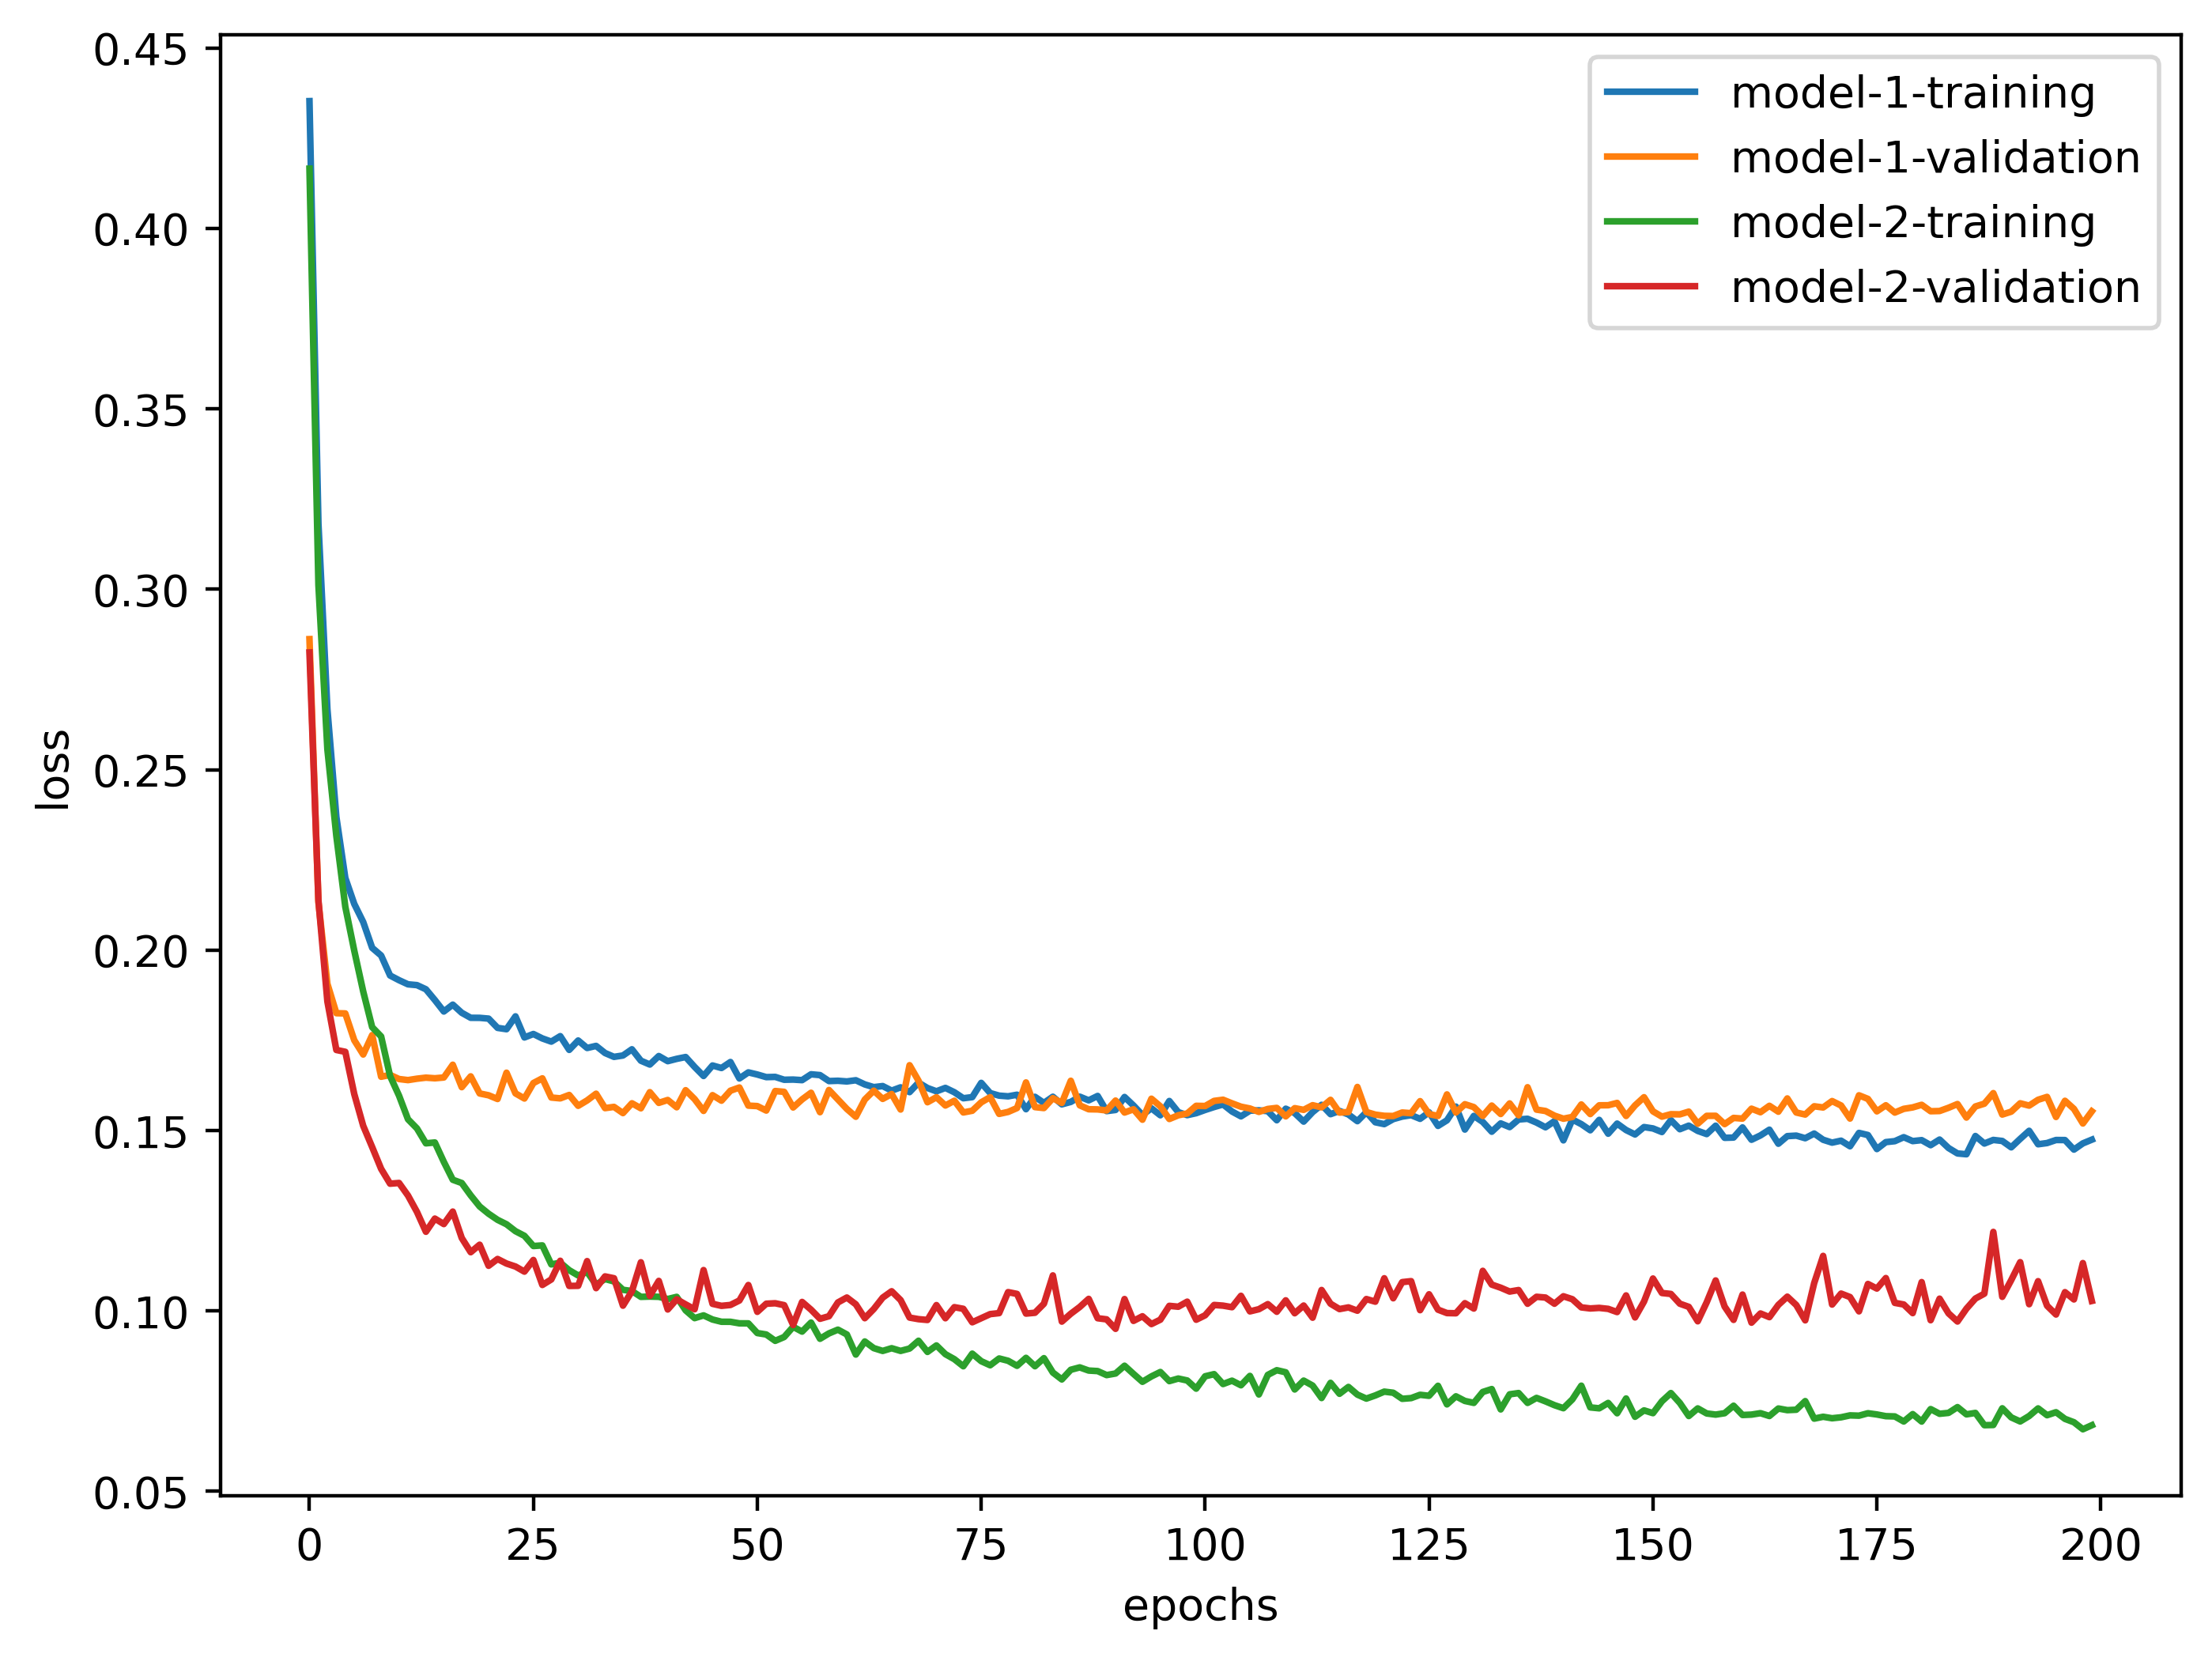

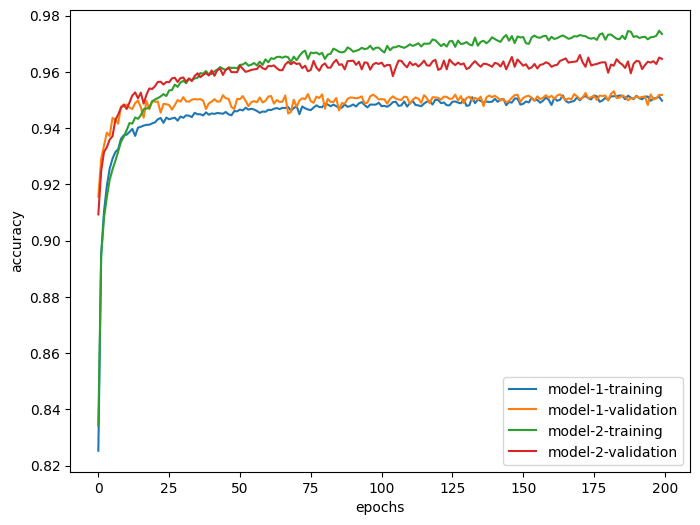

In [69]:
'''
比較兩種網路的訓練結果
'''
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(history_1.history['loss'], label='model-1-training')
plt.plot(history_1.history['val_loss'], label='model-1-validation')
plt.plot(history_2.history['loss'], label='model-2-training')
plt.plot(history_2.history['val_loss'], label='model-2-validation')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['binary_accuracy'], label='model-1-training')
plt.plot(history_1.history['val_binary_accuracy'], label='model-1-validation')
plt.plot(history_2.history['binary_accuracy'], label='model-2-training')
plt.plot(history_2.history['val_binary_accuracy'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()



In [70]:
'''
驗證在測試集上
'''

# 載入Model 1準確率最高的模型權重
model_1.load_weights(model_dir + '/Best-model-1.keras')
# 載入Model 2準確率最高的模型權重
model_2.load_weights(model_dir + '/Best-model-2.keras')
loss_1, accuracy_1 = model_1.evaluate(x_test_normal, y_test)
loss_2, accuracy_2 = model_2.evaluate(x_test_one_hot, y_test)
print("Model-1: {}%\nModel-2: {}%".format(accuracy_1, accuracy_2))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - binary_accuracy: 0.9584 - loss: 0.1288
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - binary_accuracy: 0.9685 - loss: 0.0864
Model-1: 0.9556000232696533%
Model-2: 0.9677000045776367%


用索引找寶可夢名稱

In [71]:
# 讀取數據
pokemon_df = pd.read_csv('pokemon.csv')

# 設置索引
pokemon_df.set_index('#', inplace=True)

# 定義函數
def get_pokemon_name(index):
    try:
        # 找到對應索引的寶可夢名字
        name = pokemon_df.loc[index, 'Name']
        return name
    except KeyError:
        return "Index not found"


寶可夢PK - 修正版 <br>
ps. 在pokemon.csv中的代碼需要-1，例如超夢是163，輸入時要打162<br>
不過這在fight內部有處理過了，輸入時就照著正常編號打即可

In [72]:
def fight(a,b):
    a_index = a-1
    b_index = b-1

    # 準備 One-hot 編碼的數據
    a_data_one_hot = pokemon_data_one_hot[a_index].reshape(1, -1)
    b_data_one_hot = pokemon_data_one_hot[b_index].reshape(1, -1)
    input_data_one_hot = np.concatenate([a_data_one_hot, b_data_one_hot], axis=1)

    # 使用 model_2 進行預測 (One-hot 編碼模型)
    prediction_2 = model_2.predict(input_data_one_hot)
    # 查詢寶可夢名稱
    a_name=get_pokemon_name(a)
    b_name=get_pokemon_name(b)
    # 解析預測結果
    winner = a_name if prediction_2[0] < 0.5 else b_name

    print(f"Model 2 預測結果: {winner}")


In [73]:
fight(163,321)# 超夢 vs 幕下力士
fight(7,12)# 噴火龍 vs 水箭龜
fight(3,12)# 妙蛙花 vs 水箭龜
fight(163,3)# 超夢 vs 妙蛙花

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Model 2 預測結果: Mewtwo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Model 2 預測結果: Charizard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model 2 預測結果: Venusaur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model 2 預測結果: Mewtwo
